# 1. Setup and Requirements

First, we need to set up the environment and install the required libraries.

In [ ]:
!pip install tensorflow opencv-python mediapipe
!pip install ultralytics

INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Data preparation



[Roboflow](https://app.roboflow.com/) was used to annotate images of Teakwondo players and create a data set for training and validation.

Train set : 40 images\
Validation set : 10 images

After carefully annotating images, the dataset was exported in YOLOv8 format.

Google drive: [https://drive.google.com/drive/folders/1GwW-IAPCkhTLZMHD2WjAckHszcM91BrJ?usp=sharing](https://drive.google.com/drive/folders/1GwW-IAPCkhTLZMHD2WjAckHszcM91BrJ?usp=sharing)

Under Train > data directory, exported dataset was saved for custom model training.

Dataset was preprocessed to modify the number of classes of objects to merge 'Player1', 'Player2' classes into 'Player' class.

# 3. Transfer Learning Model

In [ ]:
import os
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import yaml
import glob
import pandas as pd

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:

yaml_path = "/content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Train/data/data.yaml"

# PlayerDetection/Train  directory has train and validation dataset
# Load the yaml file to do necessary modifications
with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)

print(yaml.dump(data, sort_keys=False))

data["nc"] = 1 # number of classes = 1 ('Player')
data["names"] = ["player"]  # name of the class

with open(yaml_path, "w") as f:
    yaml.safe_dump(data, f)   #save the modifications

names:
- player
nc: 1
roboflow:
  license: CC BY 4.0
  project: player_detection_teakwondo-rmf1j
  url: https://universe.roboflow.com/taekwondoplayer/player_detection_teakwondo-rmf1j/dataset/3
  version: 3
  workspace: taekwondoplayer
test: ../test/images
train: ../train/images
val: ../valid/images



In [ ]:

train_label_files = glob.glob("/content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Train/data/train/labels/*.txt")
val_label_files = glob.glob("/content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Train/data/valid/labels/*.txt")
label_files = train_label_files + val_label_files

# during annotations in Roboflow there were two classes ('Player1' and 'Player2')
# now merge both classes into one class in train and validation sets
for file in label_files:
    with open(file, "r") as f:
        lines = f.readlines()
    new_lines = []
    for line in lines:
        parts = line.strip().split()
        parts[0] = "0"  # set class to 0 for both 0('Player1') and 1('Player2')
        new_lines.append(" ".join(parts) + "\n")
    with open(file, "w") as f:
        f.writelines(new_lines)

print("All labels converted to class 0 (player)")


All labels converted to class 0 (player)


In [ ]:
model = YOLO("yolov8n.pt")
yolo_model = model  # original model for performance comparison

Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
val: Fast image access ✅ (ping: 0.7±0.2 ms, read: 0.1±0.0 MB/s, size: 41.0 KB)
val: Scanning /content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Train/data/valid/labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 10/10 13.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 0.2it/s 5.7s
                   all         10         19      0.735      0.585      0.717      0.509
                person         10         19      0.735      0.585      0.717      0.509
Speed: 0.2ms preprocess, 13.3ms inference, 0.0ms loss, 48.4ms postprocess per image
Results saved to /content/runs/detect/val


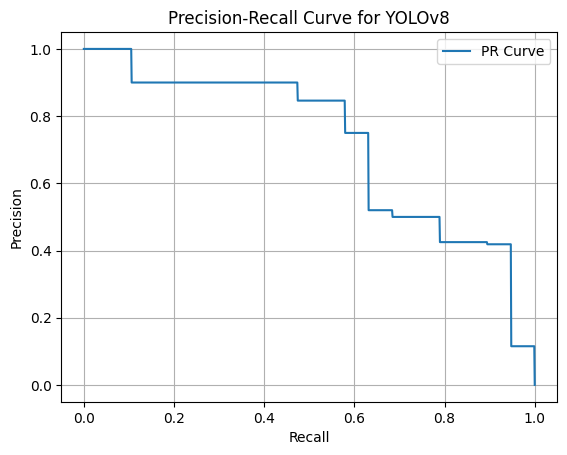

   precision    recall   mAP@0.5  mAP@0.5:0.95
0   0.735347  0.585308  0.717053      0.508547


In [ ]:
# validation images directory
val_results = yolo_model.val(data="/content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Train/data/data.yaml", plots=True)

# Precision-Recall Curve for original model
recall = val_results.curves_results[0][0]
precision = val_results.curves_results[0][1].squeeze()

plt.plot(recall, precision, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for YOLOv8")
plt.grid(True)
plt.legend()
plt.show()

# performance metrics
metrics = {
    "precision": val_results.results_dict.get("metrics/precision(B)", None),
    "recall": val_results.results_dict.get("metrics/recall(B)", None),
    "mAP@0.5": val_results.results_dict.get("metrics/mAP50(B)", None),
    "mAP@0.5:0.95": val_results.results_dict.get("metrics/mAP50-95(B)", None)
}


df = pd.DataFrame([metrics])
print(df)

In [ ]:
results = model.train(
    data="/content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Train/data/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name="player-detect"
)

# training model with the exported dataset

Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Train/data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=player-detect, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=T

In [ ]:
best_model = results.save_dir  # best weights parameters

class CustomYOLOModel:
    def __init__(self, base_model, top_k=2, conf_threshold=0.5):
        """
        Wrapping YOLO model with extra features for better customization.

        :param base_model: The YOLO model instance (e.g., YOLO("yolov8n.pt"))
        :param top_k: Maximum number of detections to keep per image
        :param conf_threshold: Confidence threshold for filtering
        """
        self.model = base_model
        self.top_k = top_k
        self.conf_threshold = conf_threshold

    def __getattr__(self, name):
        return getattr(self.model, name)

    def predict(self, source):
        results = self.model.predict(source=source, conf=self.conf_threshold)

        # filter for two players based on the probabilities
        for res in results:
            detections = res.boxes
            if len(detections) > self.top_k:
                top_idx = detections.conf.argsort(descending=True)[:self.top_k]
                res.boxes = detections[top_idx]

        return results

custom_model = CustomYOLOModel(YOLO(f"{best_model}/weights/best.pt") , top_k=2, conf_threshold=0.5)  # building custom model with best weights params

Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.8±0.3 ms, read: 22.7±2.1 MB/s, size: 36.2 KB)
val: Scanning /content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Train/data/valid/labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 10/10 20.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 2.7it/s 0.4s
                   all         10         19      0.997          1      0.995      0.683
Speed: 0.4ms preprocess, 5.5ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/runs/detect/val2


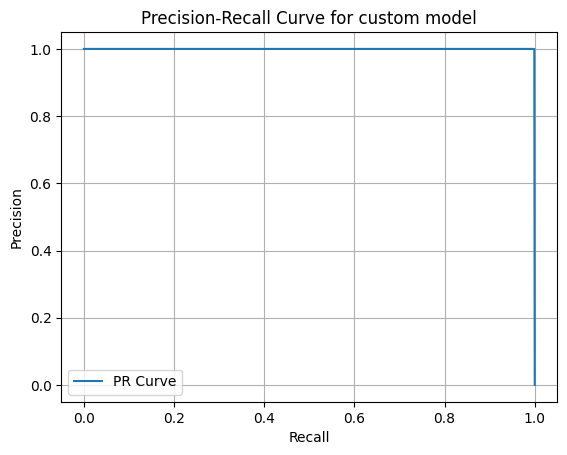

   precision  recall  mAP@0.5  mAP@0.5:0.95
0   0.996965     1.0    0.995      0.683257


In [ ]:

# Path to validation images
val_dir = "/content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Train/data/valid/images/*.jpg"
val_images = glob.glob(val_dir)

val_results = custom_model.val(data="/content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Train/data/data.yaml", plots=True)

# Precision-Recall Curve for custom model
recall = val_results.curves_results[0][0]
precision = val_results.curves_results[0][1].squeeze()

plt.plot(recall, precision, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for custom model")
plt.grid(True)
plt.legend()
plt.show()

# performance metrics
metrics = {
    "precision": val_results.results_dict.get("metrics/precision(B)", None),
    "recall": val_results.results_dict.get("metrics/recall(B)", None),
    "mAP@0.5": val_results.results_dict.get("metrics/mAP50(B)", None),
    "mAP@0.5:0.95": val_results.results_dict.get("metrics/mAP50-95(B)", None)
}

df = pd.DataFrame([metrics])
print(df)



image 1/1 /content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Test/images/frame-1.png: 640x448 8 persons, 1 chair, 70.5ms
Speed: 13.4ms preprocess, 70.5ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 448)


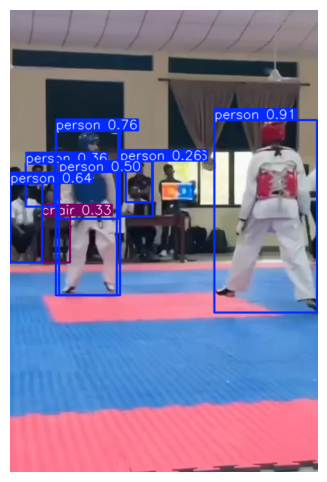


image 1/1 /content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Test/images/frame-2.png: 640x448 7 persons, 7.7ms
Speed: 3.7ms preprocess, 7.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 448)


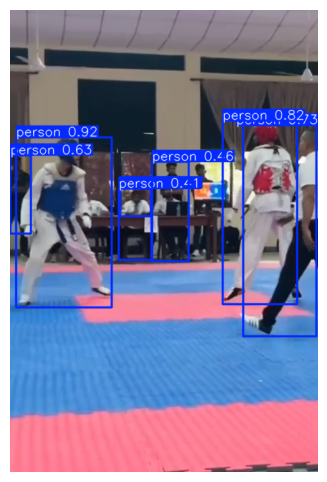


image 1/1 /content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Test/images/frame-3.png: 640x448 12 persons, 1 chair, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 448)


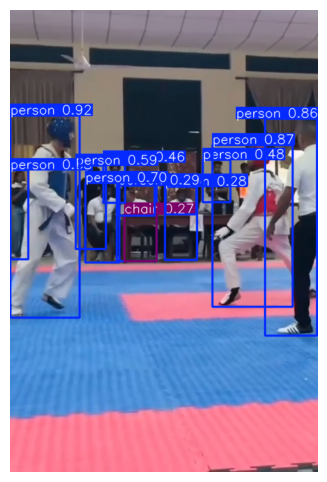


image 1/1 /content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Test/images/frame-4.png: 640x448 11 persons, 1 chair, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 448)


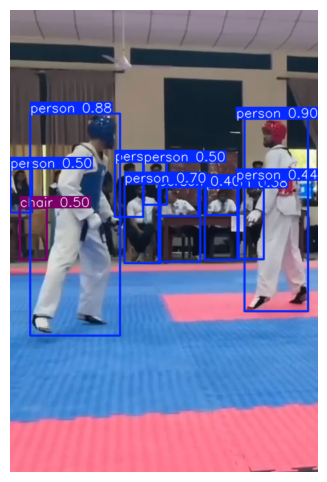


image 1/1 /content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Test/images/frame-5.png: 640x448 10 persons, 2 chairs, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 448)


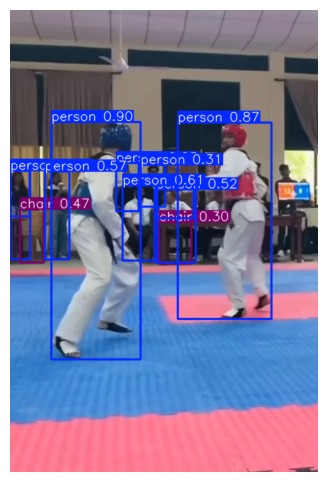


image 1/1 /content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Test/images/frame-6.png: 640x448 8 persons, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 448)


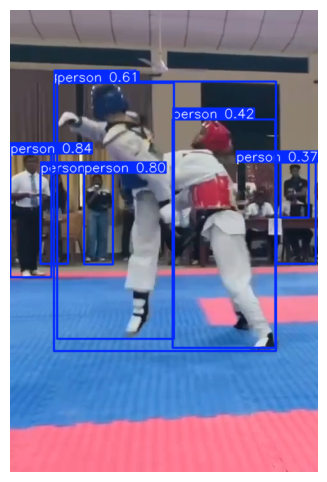


image 1/1 /content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Test/images/frame-7.png: 640x448 8 persons, 2 chairs, 11.2ms
Speed: 2.9ms preprocess, 11.2ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 448)


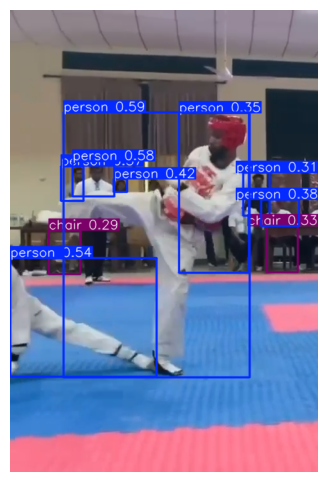


image 1/1 /content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Test/images/frame-8.png: 640x448 9 persons, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 448)


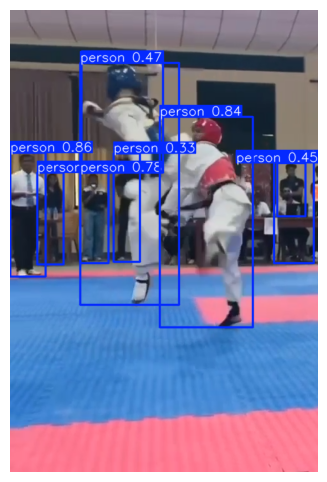

In [ ]:

# Inference on test images for original model
test_dir = "/content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Test/images/*.png"
test_images = glob.glob(test_dir)

for img in test_images:
    results = yolo_model.predict(source=img)
    annotated = results[0].plot()
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()



In [ ]:
# Inference on test images for custom model
for img in test_images:
    results = custom_model.predict(source=img)
    annotated = results[0].plot()
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [ ]:
video_path = "/content/drive/MyDrive/MSc/DS5216/PA2/PlayerDetection/Test"
video_files = []
for root, _, files in os.walk(video_path):
    for file in files:
        if file.endswith((".mp4", ".avi", ".mov", ".mkv")):  # adding supporting formats
            video_files.append(os.path.join(root, file))

print(f"Found {len(video_files)} videos")

# Creating a dict of VideoCapture objects
caps = {vf: cv2.VideoCapture(vf) for vf in video_files}
for path, cap in caps.items():
    print(f"Processing {path}")
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        results = model(frame)
        annotated_frame = results[0].plot()

        cv2_imshow(annotated_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()

cv2.destroyAllWindows()


# 4. Key point detection

In [ ]:
from ultralytics import YOLO
import mediapipe as mp
import numpy as np

# Initializing pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_draw = mp.solutions.drawing_utils

# Loading YOLOv8 pretrained pose model
model = YOLO("yolov8n-pose.pt")
original_model = model

In [ ]:
video_path = "/content/drive/MyDrive/MSc/DS5216/PA2/keyPoint/train_videos"
output_path = "/content/drive/MyDrive/MSc/DS5216/PA2/keyPoint/skeleton_images"  # output skeleton images are saved here

video_files = []
for root, _, files in os.walk(video_path):
    for file in files:
        if file.lower().endswith((".mp4", ".avi", ".mov", ".mkv")):  # adding supporting formats
            video_files.append(os.path.join(root, file))

print(f"Found {len(video_files)} videos")
os.makedirs(output_path, exist_ok=True)


for vf in video_files:
    cap = cv2.VideoCapture(vf)

    frame_idx = 0
    print(f"Processing {vf}")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # run YOLO pose model on each frame
        results = original_model.predict(source=frame, verbose=False)
        boxes = results[0].boxes
        kpts = results[0].keypoints

        if boxes is not None and len(boxes) > 2:
            # Filter for two players
            cls = boxes.cls.cpu().numpy()
            player_mask = cls == 0
            boxes = boxes[player_mask]
            kpts.data = kpts.data[player_mask]

            confs = boxes.conf.cpu().numpy()
            top2_idx = np.flip(np.argsort(confs)[-2:]).copy()
            boxes = boxes[top2_idx]
            kpts.data = kpts.data[top2_idx]

            results[0].boxes = boxes
            results[0].keypoints.data = kpts.data

        annotated_frame = results[0].plot(boxes=False)  # output image without boxes (only skeletons)

        # Save the annotated frame as an image
        out_path = os.path.join(output_path, f"frame_{frame_idx:05d}.jpg")
        cv2.imwrite(out_path, annotated_frame)
        frame_idx += 1


        cv2_imshow(annotated_frame)

    cap.release()

cv2.destroyAllWindows()


In [ ]:
model = YOLO("yolov8n-seg.pt")  # YOLOv8 segmentation model

[https://drive.google.com/drive/folders/1Ia7c0q_TPbWeIgMb8yJ0H6g-iZv2cJTv?usp=sharing](https://drive.google.com/drive/folders/1Ia7c0q_TPbWeIgMb8yJ0H6g-iZv2cJTv?usp=sharing)

In [ ]:
results = model.train(
    data="/content/drive/MyDrive/MSc/DS5216/PA2/playerKeyPointv2/data.yaml",  # path to Roboflow data.yaml
    epochs=50,
    imgsz=640,
    batch=8,
    name="player-seg",
)

Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/MSc/DS5216/PA2/playerKeyPointv2/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=player-seg, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pat

Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
YOLOv8n-seg summary (fused): 85 layers, 3,258,649 parameters, 0 gradients, 11.3 GFLOPs
val: Fast image access ✅ (ping: 0.8±0.3 ms, read: 17.8±4.8 MB/s, size: 41.8 KB)
val: Scanning /content/drive/MyDrive/MSc/DS5216/PA2/playerKeyPointv2/valid/labels.cache... 9 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 9/9 11.0Kit/s 0.0s
requirements: Ultralytics requirement ['faster-coco-eval>=1.6.7'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 1.2s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 0.0it/s 1:00
                   all          9         71      0.723      0.686      0.693       0.43      0.681      0.649      0.657      0.393
                  Head          9         19      0.

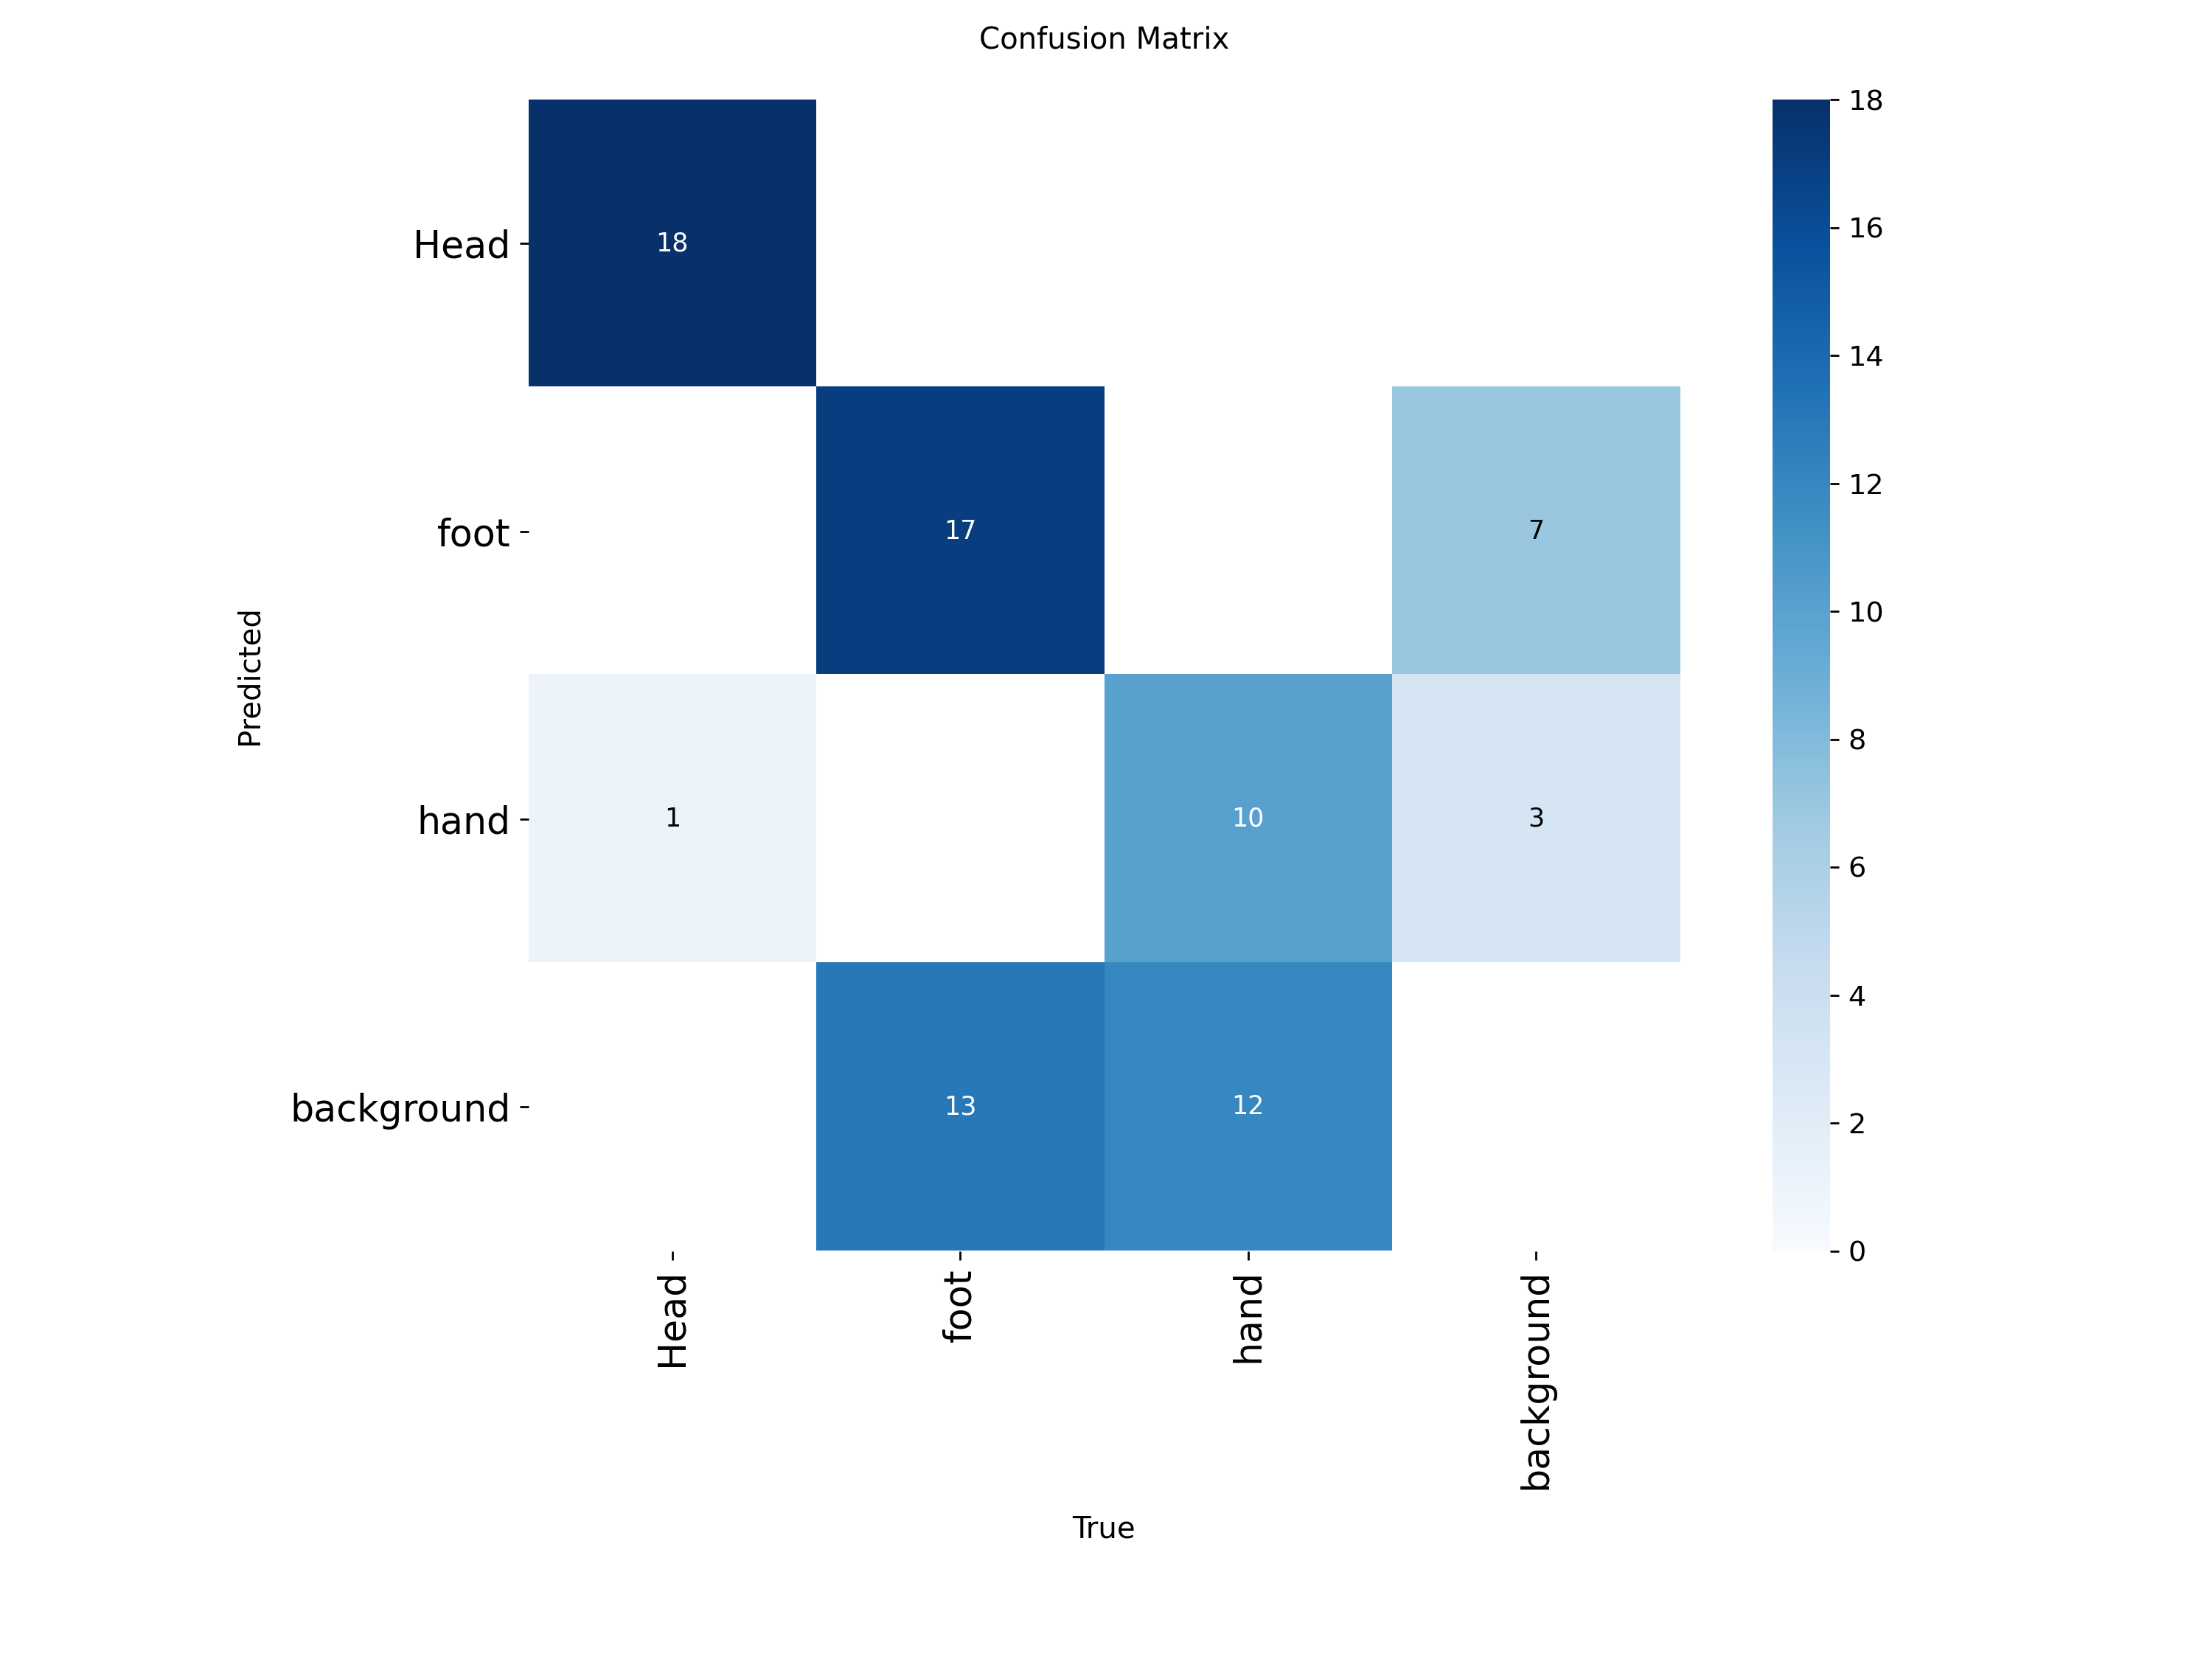

results.png not found.


In [ ]:
import pandas as pd
from IPython.display import Image, display

best_model = results.save_dir

custom_model = YOLO(f"{best_model}/weights/best.pt")

val_results = custom_model.val(
    data="/content/drive/MyDrive/MSc/DS5216/PA2/playerKeyPointv2/data.yaml",
    imgsz=640,
    batch=8,
    plots=True,      # <-- generate PR, F1, Confusion Matrix plots
    save_json=True   # optional: export COCO metrics for analysis
)

metrics = {
    "Precision": val_results.results_dict.get("metrics/precision(B)", None),
    "Recall": val_results.results_dict.get("metrics/recall(B)", None),
    "mAP@0.5": val_results.results_dict.get("metrics/mAP50(B)", None),
    "mAP@0.5:0.95": val_results.results_dict.get("metrics/mAP50-95(B)", None)
}

df = pd.DataFrame([metrics])
print("\n Evaluation Metrics:")
print(df.to_string(index=False))




0: 640x640 2 Heads, 2 foots, 284.4ms
Speed: 4.0ms preprocess, 284.4ms inference, 13.5ms postprocess per image at shape (1, 3, 640, 640)


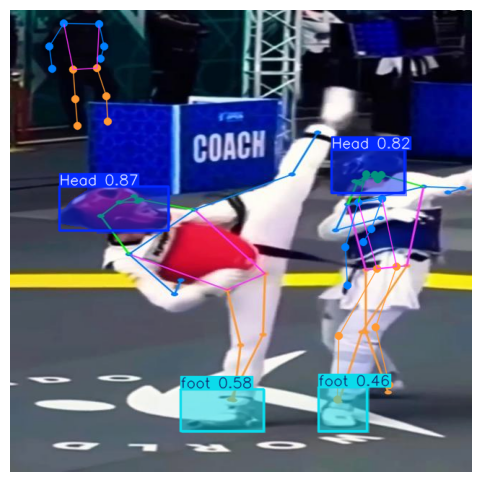


0: 640x640 3 Heads, 3 foots, 2 hands, 277.5ms
Speed: 4.3ms preprocess, 277.5ms inference, 33.6ms postprocess per image at shape (1, 3, 640, 640)


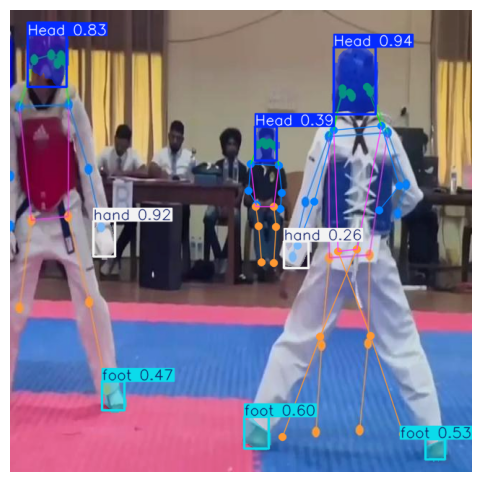


0: 640x640 2 Heads, 2 foots, 1 hand, 268.0ms
Speed: 3.3ms preprocess, 268.0ms inference, 16.9ms postprocess per image at shape (1, 3, 640, 640)


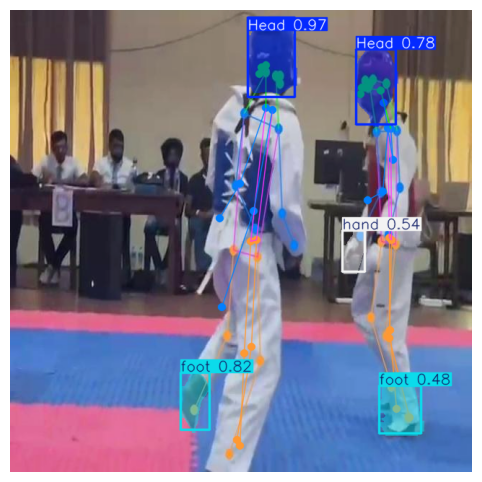


0: 640x640 2 Heads, 1 foot, 2 hands, 413.9ms
Speed: 6.6ms preprocess, 413.9ms inference, 26.6ms postprocess per image at shape (1, 3, 640, 640)


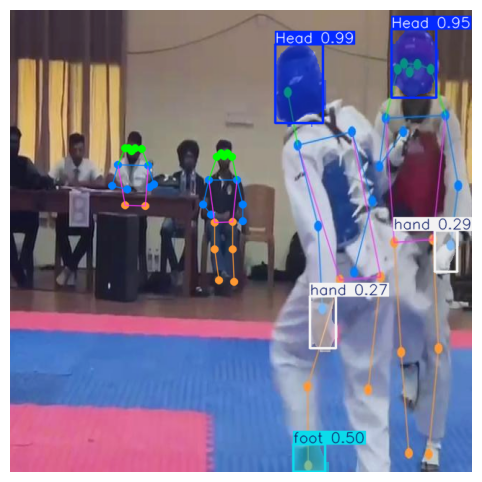


0: 640x640 2 Heads, 3 foots, 2 hands, 420.4ms
Speed: 5.8ms preprocess, 420.4ms inference, 37.6ms postprocess per image at shape (1, 3, 640, 640)


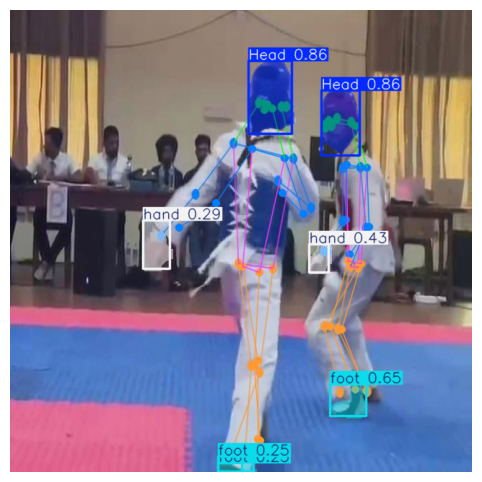


0: 640x640 2 Heads, 4 foots, 4 hands, 419.8ms
Speed: 4.0ms preprocess, 419.8ms inference, 56.7ms postprocess per image at shape (1, 3, 640, 640)


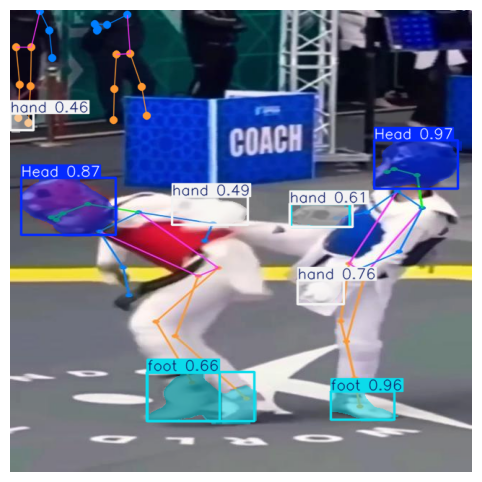


0: 640x640 2 Heads, 4 foots, 267.7ms
Speed: 4.9ms preprocess, 267.7ms inference, 19.1ms postprocess per image at shape (1, 3, 640, 640)


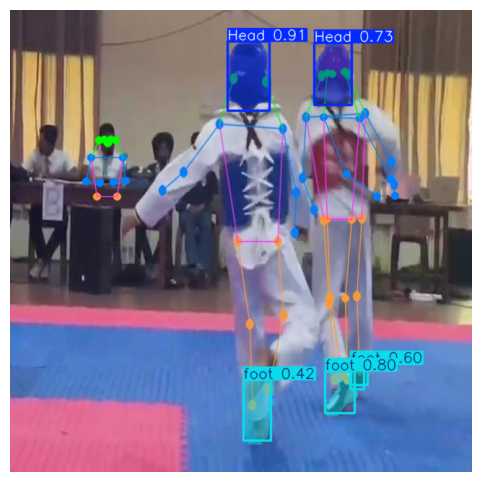


0: 640x640 2 Heads, 2 foots, 3 hands, 273.3ms
Speed: 3.7ms preprocess, 273.3ms inference, 22.2ms postprocess per image at shape (1, 3, 640, 640)


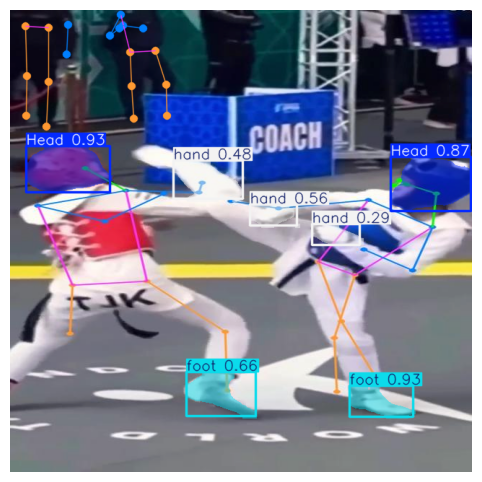


0: 640x640 2 Heads, 2 foots, 3 hands, 279.0ms
Speed: 4.0ms preprocess, 279.0ms inference, 22.7ms postprocess per image at shape (1, 3, 640, 640)


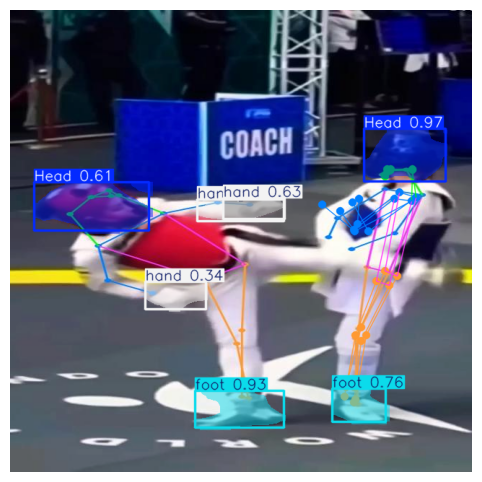

In [ ]:
# Inference on test images
val_dir = "/content/drive/MyDrive/MSc/DS5216/PA2/playerKeyPointv2/valid/images/*.jpg"
val_images = glob.glob(val_dir)

for img in val_images:
    results = original_model.predict(source=img, verbose=False)
    boxes = results[0].boxes
    kpts = results[0].keypoints

    if boxes is not None and len(boxes) > 2:
        # (Optional) Filter by class = player (class 0)
        cls = boxes.cls.cpu().numpy()
        player_mask = cls == 0
        boxes = boxes[player_mask]
        kpts.data = kpts.data[player_mask]

        # Keep top 2 by confidence
        confs = boxes.conf.cpu().numpy()
        top2_idx = np.flip(np.argsort(confs)[-2:]).copy()  # safe reverse
        boxes = boxes[top2_idx]
        kpts.data = kpts.data[top2_idx]

        results[0].boxes = boxes
        results[0].keypoints.data = kpts.data

    annotated_frame = results[0].plot(boxes=False)
    pred = custom_model.predict(source=annotated_frame)
    annotated = pred[0].plot()
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


In [ ]:
test_video = "/content/drive/MyDrive/MSc/DS5216/PA2/playerKeyPointv2/test/video1.mp4"

cap = cv2.VideoCapture(test_video)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLO (or your pose model)
    results = original_model.predict(source=frame, verbose=False)
    boxes = results[0].boxes
    kpts = results[0].keypoints

    if boxes is not None and len(boxes) > 2:
        # (Optional) Filter by class = player (class 0)
        cls = boxes.cls.cpu().numpy()
        player_mask = cls == 0
        boxes = boxes[player_mask]
        kpts.data = kpts.data[player_mask]

        # Keep top 2 by confidence
        confs = boxes.conf.cpu().numpy()
        top2_idx = np.flip(np.argsort(confs)[-2:]).copy()  # safe reverse
        boxes = boxes[top2_idx]
        kpts.data = kpts.data[top2_idx]

        results[0].boxes = boxes
        results[0].keypoints.data = kpts.data

    annotated_frame = results[0].plot(boxes=False)
    pred = custom_model.predict(source=annotated_frame)
    annotated = pred[0].plot()
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()